# Australian Thoroughbred Horseracing Analysis

## The datasets

There are five datasets we are interested in.

All of these datasets were sourced from the following websites:

* racing.com (races, horses, jockeys and trainers)
* racenet.com.au (sectional times)

All coding to create these datasets was done by the author.

The datasets cover thoroughbred races at the following courses:

* Caulfield (Melbourne)
* Flemington (Melbourne)
* Rosehill Gardens (Sydney)
* Royal Randwick (Sydney)

These courses were chosen as they are the four biggest metropolitan courses in Australia, having the greatest number of Group and Listed races. Races at these courses have the greatest prizemoney and tend to attract a lot of public interest and have large waging pools.

We extracted all races from the period 1 January 2022 to 5 August 2023, a total of 1079 races. Due to some technical restrictions, we were only able to gather sectional data for the first 3 races at all of these meets.

## Load required libraries

In [39]:
# Assert minimum versions 
import sys 
assert sys.version_info >= (3, 5) 
import sklearn 
assert sklearn.__version__ >= "0.20" 
 
# Import packages and modules that will be used 
import numpy as np 
import pandas as pd
from sklearn import linear_model
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import accuracy_score 

# Import and configure matplotlib 
%matplotlib inline  
import matplotlib as mpl  
import matplotlib.pyplot as plt 
mpl.rc('figure', dpi=120) # set good resolution

# Set a seed for reproducability
import random
random.seed(42)
# numpy needs a random seed, too
np.random.seed(42)

import datetime
from datetime import date

import seaborn as sns

## Load datasets

### Races

The historic data for horses is sourced from pages similar to this: https://www.racing.com/form/2022-08-06/flemington/race/5


In [2]:
df_races = pd.read_csv('/Users/phillipmonk/research_paper/horse_code/data/race_data.csv')
df_races.head()

,race_course,race_no,datetime,distance,class,track_cond,track_rail,race_time,prize_money,position,...,jockey,weight,prize,800m,400m,margin,horse_adjusted_t1_speed,sp,s_tab_win,s_tab_place
0,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,1,...,J.Kah,61.5,71500,4.0,3.0,0.00,62.038672,5.0,4.6,1.9
1,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,2,...,J.Richards (a2),60.5,23400,3.0,4.0,0.10,62.027217,5.0,0.0,1.9
2,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,3,...,N.Heywood,62.0,11700,1.0,1.0,0.60,61.969947,26.0,0.0,4.2
3,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,4,...,M.J.Cartwright (a2),59.5,6500,2.0,2.0,0.70,61.958494,10.0,0.0,0.0
4,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,5,...,D.Oliver,61.0,3900,8.0,8.0,1.95,61.815337,5.0,0.0,0.0


In [3]:
df_races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11881 entries, 0 to 11880
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   race_course              11881 non-null  object 
 1   race_no                  11881 non-null  int64  
 2   datetime                 11881 non-null  object 
 3   distance                 11881 non-null  int64  
 4   class                    11881 non-null  object 
 5   track_cond               11881 non-null  int64  
 6   track_rail               11881 non-null  object 
 7   race_time                11881 non-null  float64
 8   prize_money              11881 non-null  int64  
 9   position                 11881 non-null  int64  
 10  horse_name               11881 non-null  object 
 11  barrier                  11881 non-null  int64  
 12  trainer                  11881 non-null  object 
 13  jockey                   11881 non-null  object 
 14  weight                

This dataframe contains data of each runner in each race.

#### Fields

##### race_course
The racecourse (Caulfield, Flemington, Rosehill Gardens or Royal Randwick).

##### race_no
The individual race number in the meeting.

##### datetime
The date and time of the race.

##### distance  
The distance of the race. Sprints are usually around a kilometre or a bit longer, long-distance races are 2 kilometres or longer (the Melbourne cup is 3200 metres).

##### class 
The class of the race. Group 1 races are the highest, down to Group 3 then Listed races.

##### track_cond  
The rating of the track. A rating of 1 means firm and fast, 10 means a heavy bog.

##### track_rail
The position of the rail on the course.

##### race_time
The time of the winning horse, in seconds.

##### prize_money
The total amount of prize money for the race.

##### position 
The finishing position of the horse in the race.

##### horse_name
The name of the horse. Horse names should be unique therefore can be used as an identifier.

##### barrier
The starting barrier for the race. Barrier 1 is closest to the rail. The closer the barrier, the shorter the distance to the finishing post, assuming that the race includes some bends. A wider barrier might carry an advantage if the track is heavy and has been churned up close to the rail.

##### trainer
The trainer of the horse. Usually the same trainer will train a horse for an extended length of time, though it's possible the owners will decide to change trainers.

##### jockey
The jockey riding the horse in this race. It is more likely the horse will be ridden by different jockeys at different times.

##### weight
Thoroghbred horseracing in Australia is handicapped by weight; i.e., different horses will carry different weights to make the races closer and more interesting. If the jockey weighs less than the required weight they will carry extra weight in the saddle.

##### prize
The individual prize money won by this horse in this race.

##### 800m
The position the horse in with 800 metres to go.

##### 400m
The position the horse in with 400 metres to go.

##### margin
The distance in lengths the horse finished behind the winner. A value of 0 means the horse won.

##### horse_adjusted_t1_speed
This is a standardised 'speed' that we can use to attempt like-for-like comparisons of horses.

First, we convert the margin to a distance then calculate the speed using 1 length ~= 2.4 metres.

Then, adjust the speed in two different ways.

We use a formula to standardise the speeds of horses over different distances, basically calling a 60 sec 1000 metre sprint and a 210 sec 3200 metre race the same speed and using a log curve in-between as appropriate.
                
We also add a factor for the track condition.
* Track rating 1-3 means no adjustment
* For every point above 3, we increase the speed by 0.5%, so e.g. a track rating of 7 attracts a multiplier of 1.02 (2%).

##### sp
The bookmaker's payout for the horse winning the race. E.g., a figure of 10 means that a $1 wager paid out $10 ($9 profit).

##### s_tab_win
The TAB payout for the horse winning the race.

##### s_tab_place
The TAB payout for the horse finishing in the top 3 places.

In [4]:
df_races.describe()

,race_no,distance,track_cond,race_time,prize_money,position,barrier,weight,prize,800m,400m,margin,horse_adjusted_t1_speed,sp,s_tab_win,s_tab_place
count,11881.000000,11881.000000,11881.000000,11881.000000,1.188100e+04,11881.000000,11881.000000,11881.000000,1.188100e+04,11880.000000,11880.000000,11881.000000,11881.000000,11881.000000,11881.000000,11881.000000
mean,5.348035,1480.599276,5.040064,89.485173,3.309695e+05,6.396347,6.418820,56.535603,2.602399e+04,6.411785,6.407407,4.787531,61.776618,22.475755,0.684875,0.697838
std,2.727153,392.864655,1.689115,26.426646,8.709060e+05,3.757020,3.775117,2.287362,1.377079e+05,3.767928,3.764314,6.078915,1.091421,27.721223,3.595628,1.658653
min,1.000000,1000.000000,3.000000,56.060000,5.000000e+04,1.000000,1.000000,49.000000,0.000000e+00,1.000000,1.000000,0.000000,43.863471,1.180000,0.000000,0.000000
25%,3.000000,1200.000000,4.000000,70.020000,1.300000e+05,3.000000,3.000000,54.500000,2.600000e+03,3.000000,3.000000,1.560000,61.214947,7.000000,0.000000,0.000000
50%,5.000000,1400.000000,4.000000,83.810000,1.500000e+05,6.000000,6.000000,56.500000,4.000000e+03,6.000000,6.000000,3.550000,61.883866,13.000000,0.000000,0.000000
75%,8.000000,1600.000000,6.000000,98.210000,2.000000e+05,9.000000,9.000000,58.000000,1.350000e+04,9.000000,9.000000,6.150000,62.470992,26.000000,0.000000,0.000000
max,10.000000,3200.000000,10.000000,206.910000,1.500000e+07,21.000000,22.000000,65.000000,6.749000e+06,21.000000,21.000000,144.490000,64.969968,301.000000,95.900000,25.000000


#### Observations

There are a total of 11,881 data rows across 1071 races, 1 for each horse in each race.

There's a maximum of 10 races per meet. Race distances range from 1000 metres to 3200 metres. The track condition is never lower than 3 (Good) but can go as high as 10 (Very Heavy). Because these are high-profile tracks they tend to be well-maintained (good amounts of grass and moisture).

The prize money for an entire race ranges from \\$50,000 to \\$15,000,000, with a mean of \\$330,969.50.

The maximum number of finishers is 21 (note some races could have more runners that were scratched or failed to finish).

The minimum weight carried was 49kg, the maximum 65kg. The mean weight is about 56.5kg.

Individual prize money can range from zero (smaller races only tend to pay the first few finishers) to \\$6.749 million for winning the Melbourne Cup.

Lengths behind the leader at the 800m/400m marks is capped at 21 lengths (totally out of contention).

The mean margin behind the winner is about 4.79 lengths.

The SP (bookie) price is the price offered when the race started. I have zeroed the values when nothing was recorded. The mean win odds are \\$22.42. Therefore, in general, most horses are long-shots. The highest odds offered were \\$301.00.

The TAB win and place odds are the actual payouts recorded, therefore they are usually zero. The highest odds paid out were \\$95.90 for a win and \\$25 for a place.

#### Sample scatterplot of adjusted speed versus race distance
This sample scatterplot shows the effectiveness of the adjustment factor we developed to standardize speeds across different race distances. If the adjustment was perfect the red line would be horizontal.

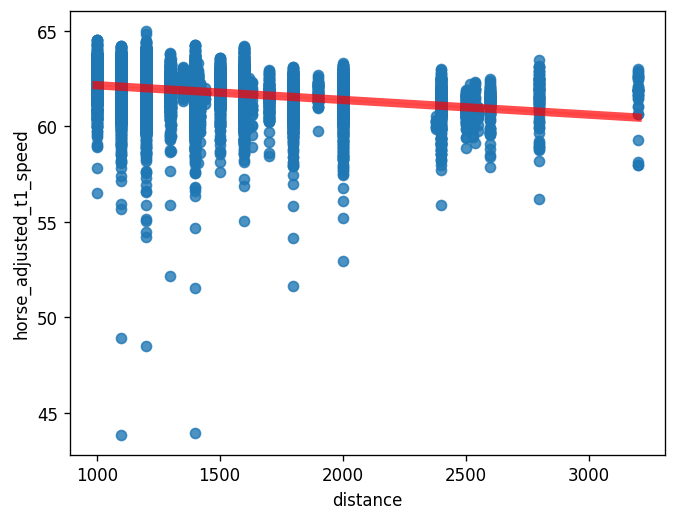

In [59]:
sns.regplot(x=df_races["distance"], y=df_races["horse_adjusted_t1_speed"], line_kws={"color":"r","alpha":0.7,"lw":5}, x_jitter=.2)
plt.show()

#### Feature Engineering

##### date

In order to be able to join to other data frames, we convert the datetime to a date. We don't need the time of day.

In [5]:
df_races['date'] = pd.to_datetime(df_races['datetime'], format='%Y-%m-%d %H:%M:%S').dt.floor('d')

##### _class
The class column is a categorical field; it would be nice to convert this to a numeric for ranking.

In [6]:
df_races['class'].unique()

array(['BM 70', 'BM 84', 'Listed', 'BM 78', 'Open', 'BM 64', 'Group 3',
       'Maiden', 'BM 58', 'Group 2', 'Group 1', 'BM 90', 'Quality'],
      dtype=object)

We create a new column, \_class, that uses numerics.

Everything that is not a group or listed race we've labelled as class 5.

In [7]:
equiv = {'Listed':4, 'BM 84':5, 'BM 70':5, 'Open':5, 'Group 3':3, 'Group 2':2, 'BM 78':5, 'BM 58':5, 'Maiden':5, 'Quality':5, 'BM 64':5, 'BM 90':5, 'Group 1':1}
df_races['_class'] = df_races['class'].map(equiv)

##### market_prob

The bookie (SP) odds are inflated to ensure bookies make a profit, in the long run. We want to know what the 'market' thinks the probability of the horse winning really is. So we need to calculate the markup for each race then reduce the probabilities by that. 

To do this, we first invert the odds quoted for each horse:

i.e., for each p(i), calculate 1/p(i) for each horse i (1,2,3,..,n) in a field of n horses.

Then, add the probabilities up:

Sum 1/p(i) for each horse i (1,2,3,...,n) = S.

Divide the inverted odds by S to get the true 'market' odds:

1/(p(i) * S)

The sum of the market odds should equal 1.

In [8]:
df_races['inv_sp'] = 1/df_races['sp']

mark_up = df_races.groupby(['race_course','date','race_no'])['inv_sp'].sum()

df_markup = mark_up.to_frame()

df_markup = df_markup.rename(columns={"inv_sp": "markup"})

df_markup

markup
race_course    date       race_no          
Caulfield      2022-01-08 1        1.133958
                          2        1.160287
                          3        1.146317
                          4        1.164391
                          5        1.152420
...                                     ...
Royal Randwick 2023-07-29 6        1.195342
                          7        1.192343
                          8        1.208435
                          9        1.204525
                          10       1.206800

[1071 rows x 1 columns]

In [9]:
# We check for zero values
df_races.race_course[df_races.sp==0].count()

0

In [10]:
df_markup.describe()

,markup
count,1071.000000
mean,1.172296
std,0.044070
min,0.621020
25%,1.166287
50%,1.180752
75%,1.191656
max,1.248669


In [11]:
# We check for low values
df_markup.markup[df_markup.markup<1]

race_course       date        race_no
Caulfield         2022-04-09  6          0.956753
                  2022-10-12  7          0.672259
Flemington        2022-02-19  6          0.952590
                  2023-03-11  4          0.968964
                  2023-06-03  5          0.967507
Rosehill Gardens  2022-07-02  5          0.841745
                  2022-08-27  8          0.900851
                  2022-09-24  10         0.992137
                  2022-11-05  3          0.828848
                  2022-11-26  3          0.975593
                  2023-02-18  3          0.924464
                  2023-03-18  8          0.999202
                  2023-08-05  8          0.942881
Royal Randwick    2022-11-01  4          0.621020
                  2023-02-04  1          0.949203
Name: markup, dtype: float64

##### Observation
The median and mean markup are around 17-18%. This markup is what we must overcome to develop a profitable wagering strategy. There are a handful of races where the odds sum up to less than 1. In theory this means a punter could 'cover the field' (bet on all runners) and make a profit. In practice, it probably means that there were late scratchings (horses that ultimately did not run) which it may not have been practical to take advantage of.

Now calculate the 'market' probabilities for each runner in each race.

In [12]:
# Merge the markup into the dataframe
df_races_prob = pd.merge(df_races, df_markup, on=['race_course', 'date', 'race_no'], how='inner')

df_races_prob['market_prob'] = df_races_prob['inv_sp']/df_races_prob['markup']

df_races_prob

,race_course,race_no,datetime,distance,class,track_cond,track_rail,race_time,prize_money,position,...,margin,horse_adjusted_t1_speed,sp,s_tab_win,s_tab_place,date,_class,inv_sp,markup,market_prob
0,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,1,...,0.00,62.038672,5.0,4.6,1.9,2022-01-01,5,0.200000,1.173895,0.170373
1,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,2,...,0.10,62.027217,5.0,0.0,1.9,2022-01-01,5,0.200000,1.173895,0.170373
2,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,3,...,0.60,61.969947,26.0,0.0,4.2,2022-01-01,5,0.038462,1.173895,0.032764
3,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,4,...,0.70,61.958494,10.0,0.0,0.0,2022-01-01,5,0.100000,1.173895,0.085187
4,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,5,...,1.95,61.815337,5.0,0.0,0.0,2022-01-01,5,0.200000,1.173895,0.170373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11876,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,7,...,3.91,61.643355,6.5,0.0,0.0,2023-08-05,5,0.153846,1.204852,0.127689
11877,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,8,...,4.39,61.600643,21.0,0.0,0.0,2023-08-05,5,0.047619,1.204852,0.039523
11878,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,9,...,5.84,61.471627,21.0,0.0,0.0,2023-08-05,5,0.047619,1.204852,0.039523
11879,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,10,...,5.89,61.467179,31.0,0.0,0.0,2023-08-05,5,0.032258,1.204852,0.026773


#### Mapping market probabilities against finishing position
The graph of market probability versus finishing position shows there's a clear trend that a higher finishing position is correlated with better odds of victory.

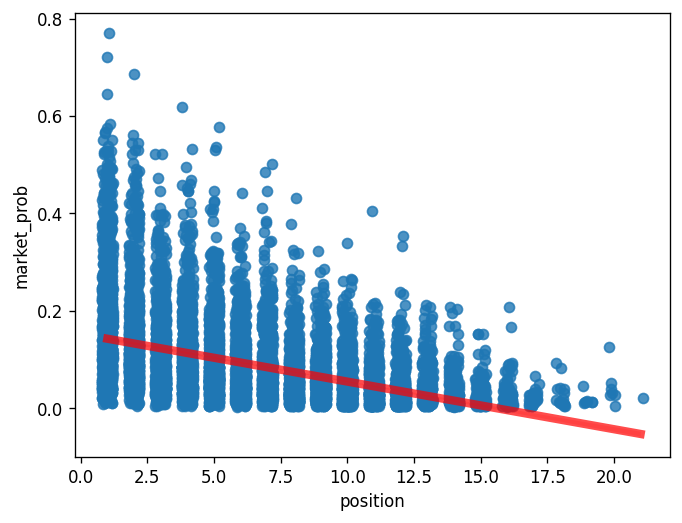

In [58]:
sns.regplot(x=df_races_prob["position"], y=df_races_prob["market_prob"], line_kws={"color":"r","alpha":0.7,"lw":5}, x_jitter=.2)
plt.show()

##### horse_adjusted_t-n_speed

We include the last 3 'speeds' for the horse for reference, then calculate the mean recent 'speed'.

In [13]:
df_races = df_races.sort_values(by=["horse_name", "datetime", "race_course", "race_no"])
df_races["horse_adjusted_t-1_speed"] = df_races.groupby("horse_name")["horse_adjusted_t1_speed"].shift(1)
df_races["horse_adjusted_t-2_speed"] = df_races.groupby("horse_name")["horse_adjusted_t1_speed"].shift(2)
df_races["horse_adjusted_t-3_speed"] = df_races.groupby("horse_name")["horse_adjusted_t1_speed"].shift(3)

df_races

,race_course,race_no,datetime,distance,class,track_cond,track_rail,race_time,prize_money,position,...,horse_adjusted_t1_speed,sp,s_tab_win,s_tab_place,date,_class,inv_sp,horse_adjusted_t-1_speed,horse_adjusted_t-2_speed,horse_adjusted_t-3_speed
404,Flemington,6,2022-01-21 17:30:00,1000,BM 70,3,Out 12m Entire Circuit,57.74,50000,10,...,61.454456,6.0,0.0,0.0,2022-01-21,5,0.166667,NaN,NaN,NaN
6902,Royal Randwick,4,2022-12-24 14:05:00,1100,BM 70,4,+9m Entire,63.57,120000,4,...,62.870796,13.0,0.0,0.0,2022-12-24,5,0.076923,NaN,NaN,NaN
5145,Royal Randwick,1,2022-10-15 12:30:00,1400,Listed,7,True,83.94,160000,1,...,62.852105,9.0,9.2,3.0,2022-10-15,4,0.111111,NaN,NaN,NaN
5358,Royal Randwick,7,2022-10-22 16:10:00,1600,Group 2,6,+4m Entire Course,98.89,1000000,3,...,61.044756,5.5,0.0,1.8,2022-10-22,2,0.181818,62.852105,NaN,NaN
7894,Royal Randwick,7,2023-02-11 16:00:00,1200,Group 2,4,True,70.20,250000,10,...,62.342791,51.0,0.0,0.0,2023-02-11,2,0.019608,61.044756,62.852105,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,Caulfield,10,2022-10-08 17:45:00,1200,Group 3,5,True Entire Circuit,70.05,200000,8,...,62.753113,15.0,0.0,0.0,2022-10-08,3,0.066667,61.517441,61.704272,61.557003
4566,Flemington,1,2022-10-01 12:40:00,1000,Listed,4,Out 9m Entire Circuit,57.90,175000,1,...,62.487047,8.0,8.3,2.1,2022-10-01,4,0.125000,NaN,NaN,NaN
5644,Flemington,1,2022-11-01 10:45:00,1000,Group 3,5,Out 2m Entire Circuit,58.52,200000,5,...,61.650918,4.0,0.0,0.0,2022-11-01,3,0.250000,62.487047,NaN,NaN
8567,Rosehill Gardens,2,2023-03-11 12:55:00,1200,Group 3,4,True,70.56,200000,7,...,61.758726,5.0,0.0,0.0,2023-03-11,3,0.200000,61.650918,62.487047,NaN


### Horses

The historic data for horses is sourced from pages similar to this: https://www.racing.com/horses/stageman

Note, we excluded trial results from the study (these are coloured grey on the website, and notably offer no prize money).

The motivation for including the historical horse data is:

* we get high-level data such as age, sex, career performance and prize money
* we get data on the rating of the horse at the time of each race
* we can calculate if the horse is returning from a spell (a minimum two-month break from racing)

Spells are designed to 'freshen' the horse. If there is a high-profile race some time in the future that the trainer would like the horse to peak for, the trainer may spell the horse several months before, then give it a couple of races as a warm-up before the Big Event. It may be that the trainer is not so worried about the horse's performance in its first couple of races returning from a spell.


In [14]:
df_horses = pd.read_csv('/Users/phillipmonk/research_paper/horse_code/data/horse_data.csv')
df_horses.head()

,horse_name,foaled,colour,sire,dam,sex,prize_money,season,grp_listed,first_up,...,horse_t0_percent_top2,horse_t0_percent_top1,horse_t3_prestige_max,horse_t3_prestige_median,horse_t3_prestige_mean,horse_t3_position_median,horse_t3_position_mean,horse_t3_top3,horse_t3_top2,horse_t3_top1
0,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.000000,0.000000,31500.0,0.0,10500.000000,3,1,1,0,0
1,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.000000,0.000000,60000.0,31500.0,30500.000000,6,3,1,0,0
2,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.333333,0.333333,60000.0,31500.0,41000.000000,6,3,2,1,1
3,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.250000,0.250000,125000.0,60000.0,72166.666667,6,3,2,1,1
4,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.200000,0.200000,125000.0,75000.0,77166.666667,3,2,3,1,1


In [15]:
df_horses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50257 entries, 0 to 50256
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   horse_name                50257 non-null  object 
 1   foaled                    50257 non-null  object 
 2   colour                    50257 non-null  object 
 3   sire                      50257 non-null  object 
 4   dam                       50257 non-null  object 
 5   sex                       50257 non-null  object 
 6   prize_money               50242 non-null  float64
 7   season                    50257 non-null  object 
 8   grp_listed                50257 non-null  object 
 9   first_up                  50257 non-null  object 
 10  second_up                 50257 non-null  object 
 11  third_up                  50257 non-null  object 
 12  firm                      50257 non-null  object 
 13  good                      50257 non-null  object 
 14  soft  

This dataframe contains the form (history) for each horse. Note that this includes races at other tracks than the four in scope.

#### Fields

##### horse_name
The name of the horse. Horse names should be unique therefore can be used as an identifier.

##### foaled
Date of birth.

##### colour
The colour of the horse.

##### sire
The horse's father.

##### dam
The horse's mother.

##### sex
The horse's sex.

##### group_1_wins
Total number of group 1 wins.

##### starts
Races started.

##### firsts
Number of races won.

##### seconds 
Number of races that the horse finished second.

##### thirds
Number of races that the horse finished third.

##### prize_money
The total amount of prize money the horse has won.

##### season
The performance of the horse over the season (starts, wins, seconds, thirds).

##### grp_listed
The performance of the horse over group and listed races (starts, wins, seconds, thirds).

##### first up
The performance of the horse in the first race after a spell (starts, wins, seconds, thirds).

##### second_up
The performance of the horse in the second race after a spell (starts, wins, seconds, thirds).

##### third_up
The performance of the horse in the third race after a spell (starts, wins, seconds, thirds).

##### firm
The performance of the horse on firm tracks (starts, wins, seconds, thirds), i.e., the track condition is 1 or 2.

##### good
The performance of the horse on good tracks (starts, wins, seconds, thirds), i.e., the track condition is 3 or 4.

##### soft
The performance of the horse on soft tracks (starts, wins, seconds, thirds), i.e., the track condition is 5, 6 or 7.

##### heavy
The performance of the horse on heavy tracks (starts, wins, seconds, thirds), i.e., the track condition is 8, 9 or 10.

##### jumps
The performance of the horse on steeplechases. None of these races are in scope.

##### synth
The performance of the horse on steeplechases. None of these races are in scope.

##### position
The finishing position of the horse in each individual race.

##### num_runners
The number of runners in each individual race.

##### trainer
The trainer for the horse for that race.

##### prize_pool
The total amount of prize money for the race.

##### _class
The class of the race - Group 1, Group 2, et cetera.

##### jockey
The jockey for the horse for that race.

##### track
The track and race number for the race.

##### date
The date of the race meet.

##### dist
The distance of the race.

##### cond
The condition of the track for the race.

##### weight
The weight the horse carried for the race.

##### 800m
The position of the horse with 800 metres to go in the race.

##### 400m
The position of the horse with 400 metres to go in the race.

##### margin
The distance behind the winner in lengths the horse finished in the race.

##### rating
The rating of the horse during the race.

##### odds
The odds for a win for the horse at the beginning of the race.

##### odds_source
The source of the odds for the race, typically SP (bookmaker) or TAB.

##### horse_t0_prestige_max
Maximum prize pool won in all races.

##### horse_t0_prestige_median
Median prize pool won in all races.

##### horse_t0_prestige_mean
Mean prize pool in all races.

##### horse_t0_position_median
Median place in all races.

##### horse_t0_position_mean
Mean position in all races.

##### horse_t0_top3
Number of times in the top 3.

##### horse_t0_top2
Number of times in the top 2.

##### horse_t0_percent_top3
Percent of times in the top 3.

##### horse_t0_percent_top2
Percent of times in the top 2.

##### horse_t0_percent_top1
Percent of times won.

##### horse_t3_prestige_max
Maximum prize pool in last 3 races.

##### horse_t3_prestige_median
Median prize pool in last 3 races.

##### horse_t3_prestige_mean
Mean prize pool in last 3 races.

##### horse_t3_position_median 
Median position in last 3 races.

##### horse_t3_position_mean  
Mean position in last 3 races.

##### horse_t3_top3  
Number of times in the top 3 in the last 3 races.

##### horse_t3_top2
Number of times in the top 2 in the last 3 races.

##### horse_t3_top1
Number of times won in the last 3 races.

The date field needs to be converted to a datetime so we can join on it later.

In [16]:
df_horses['date'] = pd.to_datetime(df_horses['date'], format='%Y-%m-%d').dt.floor('d')

The "horse_..." parameters need to be shifted down one row so the predictions can be made based on historic, not future, data.

In [17]:
df_horses.horse_t0_prestige_max = df_horses.groupby("horse_name")["horse_t0_prestige_max"].shift(1)
df_horses.horse_t0_prestige_median = df_horses.groupby("horse_name")["horse_t0_prestige_median"].shift(1)
df_horses.horse_t0_prestige_mean = df_horses.groupby("horse_name")["horse_t0_prestige_mean"].shift(1)
df_horses.horse_t0_position_median = df_horses.groupby("horse_name")["horse_t0_position_median"].shift(1)
df_horses.horse_t0_position_mean = df_horses.groupby("horse_name")["horse_t0_position_mean"].shift(1)
df_horses.horse_t0_top3 = df_horses.groupby("horse_name")["horse_t0_top3"].shift(1)
df_horses.horse_t0_top2 = df_horses.groupby("horse_name")["horse_t0_top2"].shift(1)
df_horses.horse_t0_percent_top3 = df_horses.groupby("horse_name")["horse_t0_percent_top3"].shift(1)
df_horses.horse_t0_percent_top2 = df_horses.groupby("horse_name")["horse_t0_percent_top2"].shift(1)
df_horses.horse_t0_percent_top1 = df_horses.groupby("horse_name")["horse_t0_percent_top1"].shift(1)
df_horses.horse_t3_prestige_max = df_horses.groupby("horse_name")["horse_t3_prestige_max"].shift(1)
df_horses.horse_t3_prestige_median = df_horses.groupby("horse_name")["horse_t3_prestige_median"].shift(1)
df_horses.horse_t3_prestige_mean = df_horses.groupby("horse_name")["horse_t3_prestige_mean"].shift(1)
df_horses.horse_t3_position_median = df_horses.groupby("horse_name")["horse_t3_position_median"].shift(1)
df_horses.horse_t3_position_mean = df_horses.groupby("horse_name")["horse_t3_position_mean"].shift(1)
df_horses.horse_t3_top3 = df_horses.groupby("horse_name")["horse_t3_top3"].shift(1)
df_horses.horse_t3_top2 = df_horses.groupby("horse_name")["horse_t3_top2"].shift(1)
df_horses.horse_t3_top1 = df_horses.groupby("horse_name")["horse_t3_top1"].shift(1)

df_horses

,horse_name,foaled,colour,sire,dam,sex,prize_money,season,grp_listed,first_up,...,horse_t0_percent_top2,horse_t0_percent_top1,horse_t3_prestige_max,horse_t3_prestige_median,horse_t3_prestige_mean,horse_t3_position_median,horse_t3_position_mean,horse_t3_top3,horse_t3_top2,horse_t3_top1
0,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.000000,0.000000,31500.0,0.0,10500.000000,3.0,1.0,1.0,0.0,0.0
2,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.000000,0.000000,60000.0,31500.0,30500.000000,6.0,3.0,1.0,0.0,0.0
3,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.333333,0.333333,60000.0,31500.0,41000.000000,6.0,3.0,2.0,1.0,1.0
4,A Good Yarn,2013-09-18,Brown or Black,O'lonhro,Little Thread,Gelding,204295.0,0–0–0–0,0–0–0–0,11–1–1–0,...,0.250000,0.250000,125000.0,60000.0,72166.666667,6.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50252,Zulfiqar,2020-07-31,Bay,Exceed And Excel,Sayf Shamal (USA),Colt,238990.0,0–0–0–0,6–2–0–0,2–2–0–0,...,1.000000,1.000000,175000.0,0.0,58333.333333,1.0,0.0,1.0,1.0,1.0
50253,Zulfiqar,2020-07-31,Bay,Exceed And Excel,Sayf Shamal (USA),Colt,238990.0,0–0–0–0,6–2–0–0,2–2–0–0,...,0.500000,0.500000,200000.0,175000.0,125000.000000,5.0,2.0,1.0,1.0,1.0
50254,Zulfiqar,2020-07-31,Bay,Exceed And Excel,Sayf Shamal (USA),Colt,238990.0,0–0–0–0,6–2–0–0,2–2–0–0,...,0.666667,0.666667,200000.0,200000.0,191666.666667,5.0,2.0,2.0,2.0,2.0
50255,Zulfiqar,2020-07-31,Bay,Exceed And Excel,Sayf Shamal (USA),Colt,238990.0,0–0–0–0,6–2–0–0,2–2–0–0,...,0.500000,0.500000,2000000.0,200000.0,800000.000000,10.0,5.0,1.0,1.0,1.0


In [18]:
df_horses.describe()

,prize_money,position,num_runners,prize_pool,_class,race_no,date,group_1_wins,starts,firsts,...,horse_t0_percent_top2,horse_t0_percent_top1,horse_t3_prestige_max,horse_t3_prestige_median,horse_t3_prestige_mean,horse_t3_position_median,horse_t3_position_mean,horse_t3_top3,horse_t3_top2,horse_t3_top1
count,5.024200e+04,50257.000000,50257.000000,5.025700e+04,50257.000000,50257.000000,50257,50257.000000,50257.000000,50257.000000,...,46985.000000,46985.000000,4.698500e+04,4.698500e+04,4.698500e+04,46985.000000,46985.000000,46985.000000,46985.000000,46985.000000
mean,3.559473e+05,4.835903,10.661918,1.615307e+05,4.637841,5.086615,2022-07-05 03:22:00.102672384,0.020156,9.959687,1.927930,...,0.371750,0.215801,2.724695e+05,1.081261e+05,1.472115e+05,7.065893,4.032159,1.265872,0.936256,0.537533
min,1.350000e+03,1.000000,3.000000,4.664000e+03,1.000000,1.000000,2007-11-21 00:00:00,0.000000,1.000000,0.000000,...,0.000000,0.000000,5.632000e+03,0.000000e+00,1.877333e+03,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.054750e+05,2.000000,9.000000,3.500000e+04,5.000000,3.000000,2021-12-18 00:00:00,0.000000,4.000000,1.000000,...,0.214286,0.076923,4.900000e+04,3.430000e+04,3.500000e+04,4.000000,2.000000,1.000000,0.000000,0.000000
50%,1.881780e+05,4.000000,10.000000,5.500000e+04,5.000000,5.000000,2022-09-05 00:00:00,0.000000,9.000000,2.000000,...,0.333333,0.181818,1.170000e+05,5.000000e+04,6.600667e+04,7.000000,4.000000,1.000000,1.000000,0.000000
75%,3.470500e+05,7.000000,12.000000,1.462500e+05,5.000000,7.000000,2023-03-13 00:00:00,0.000000,15.000000,3.000000,...,0.500000,0.300000,1.522500e+05,1.300000e+05,1.225000e+05,9.000000,6.000000,2.000000,1.000000,1.000000
max,2.076501e+07,26.000000,30.000000,1.500000e+07,5.000000,11.000000,2023-09-15 00:00:00,5.000000,30.000000,14.000000,...,1.000000,1.000000,1.500000e+07,1.500000e+07,1.134195e+07,26.000000,16.000000,3.000000,3.000000,3.000000
std,7.796193e+05,3.388646,2.774304,5.410638e+05,0.935429,2.545018,NaN,0.188123,6.584535,1.610311,...,0.243158,0.201633,8.603213e+05,2.708163e+05,3.743367e+05,3.417262,2.299200,0.927299,0.859316,0.686087


In [19]:
df_horses['horse_name'].nunique()

3272

#### Observations

There are 50,257 rows of horse observations for 3272 horses. The reason this number is higher than the observations in the Races data frame is that the data is historic for the horse, and includes races before 2022 and at other racetracks. Usually a horse would start its career at smaller tracks and would only 'graduate' to the courses in scope after having proven itself elsewhere.

There are only a handful of Group 1 races every year, so Group 1 wins are rare. Almost all horses have zero.

Horses have a mean of about 23 starts. This reflects that most horses have already had some expererience racing, with on average 4 wins, 3 seconds and 3 thirds, and about \\$356,000 in winnings. The winningest horse has over \\$20 million in career winnings.

On average a race has about 10-11 runners, with a maximum of 30.

The 'prize' column is the total prize pool for that race. The median value is \\$55,000; the mean is quite a bit higher at \\$161,307.

Races range from an 800m sprint to a whopping 4600m long-distance event. Most races are around 1400 metres. Track conditions range from 2 to 10, with most being a 4 to 6. Weight carried ranges from a svelte 49kg to a husky 76kg.

800m/400m lengths behind data is a little lower than in the races table (5.5-5.6 here as opposed to 6.4 in the Races data frame). This is probably due to the fact that these horses tended to finish closer to the front in their early careers racing against lower-quality opposition. Similarly, the margin here is 3.96 as opposed to 4.79 in the Races data frame.

The odds quoted are the odds offered by Set-Price (SP) bookmakers at the start of the race.

Here's the entire record for the 2022 Melbourne Cup winner, Gold Trip.

In [20]:
df_horses[df_horses['horse_name'] == 'Gold Trip (FR)']

,horse_name,foaled,colour,sire,dam,sex,prize_money,season,grp_listed,first_up,...,horse_t0_percent_top2,horse_t0_percent_top1,horse_t3_prestige_max,horse_t3_prestige_median,horse_t3_prestige_mean,horse_t3_position_median,horse_t3_position_mean,horse_t3_top3,horse_t3_top2,horse_t3_top1
16908,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16909,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,1.000000,0.000000,43810.0,0.0,1.460333e+04,2.0,0.0,1.0,1.0,0.0
16910,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.500000,0.000000,55168.0,43810.0,3.299267e+04,5.0,2.0,1.0,1.0,0.0
16911,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.666667,0.000000,55168.0,50352.0,4.977667e+04,5.0,3.0,2.0,2.0,0.0
16912,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.750000,0.250000,161765.0,55168.0,8.909500e+04,5.0,2.0,2.0,2.0,1.0
16913,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.600000,0.200000,1617003.0,161765.0,6.097067e+05,11.0,4.0,2.0,2.0,1.0
16914,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.500000,0.166667,1617003.0,646899.0,8.085557e+05,11.0,5.0,2.0,1.0,1.0
16915,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.428571,0.142857,5390026.0,1617003.0,2.551309e+06,11.0,6.0,1.0,0.0,0.0
16916,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.375000,0.125000,5390026.0,2059243.0,2.698723e+06,5.0,4.0,1.0,0.0,0.0
16917,Gold Trip (FR),2017-03-10,Bay,Outstrip (GB),Sarvana (FR),Horse,6337414.0,1–0–0–0,17–2–3–4,8–0–3–3,...,0.444444,0.111111,5390026.0,2059243.0,2.641493e+06,5.0,3.0,1.0,1.0,0.0


### Jockeys

Jockey data is sourced from pages similar to this:

https://www.racing.com/jockeys/kerrin-mcevoy/stats

There is a wealth of data available on those pages, to keep things manageable we only look at the career summary and the class statistics.

In [21]:
df_jockeys = pd.read_csv('/Users/phillipmonk/research_paper/horse_code/data/jockey_data.csv')
df_jockeys.head()

,jockey,jockey_career_wins,jockey_group_1_wins,jockey_prize_money,jockey_win_pct,jockey_recent_win_pct,jockey_group_1_win_pct,jockey_group_1_place_pct,jockey_group_2_win_pct,jockey_group_2_place_pct,jockey_group_3_win_pct,jockey_group_3_place_pct,jockey_listed_win_pct,jockey_listed_place_pct,jockey_other_win_pct,jockey_other_place_pct
0,aaron-bullock,836,0,18266124,19.0,24.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,15.0,19,45
1,adam-hyeronimus,535,1,20898420,13.0,22.0,3.0,13.0,2.0,9.0,6.0,17.0,13.0,33.0,13,36
2,adam-mccabe,208,0,4751110,9.0,6.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,7.0,9,29
3,alana-kelly,214,0,10565677,7.0,4.0,0.0,0.0,50.0,50.0,0.0,12.0,4.0,8.0,7,25
4,alexandra-bryan,95,0,1985574,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,21


In [22]:
df_jockeys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   jockey                    250 non-null    object 
 1   jockey_career_wins        250 non-null    int64  
 2   jockey_group_1_wins       250 non-null    int64  
 3   jockey_prize_money        250 non-null    int64  
 4   jockey_win_pct            249 non-null    float64
 5   jockey_recent_win_pct     241 non-null    float64
 6   jockey_group_1_win_pct    167 non-null    float64
 7   jockey_group_1_place_pct  167 non-null    float64
 8   jockey_group_2_win_pct    172 non-null    float64
 9   jockey_group_2_place_pct  172 non-null    float64
 10  jockey_group_3_win_pct    198 non-null    float64
 11  jockey_group_3_place_pct  198 non-null    float64
 12  jockey_listed_win_pct     219 non-null    float64
 13  jockey_listed_place_pct   219 non-null    float64
 14  jockey_oth

The jockeys data frame contains summary statistical information about jockeys. All of these jockeys were involved in at least one race in scope, but the summary data is across their entire career.

#### Fields

##### jockey_name
The name of the jockey.

##### jockey_career_wins
Total number of career wins for the jockey.

##### jockey_group_1_wins
The total number of group 1 wins for the jockey.

##### jockey_prize_money
The total amount of prize money won by the jockey.

##### jockey_win_pct
The total win percentage for the jockey.

##### jockey_recent_win_pct
The win percentage of the jockey over the last 50 races.

##### jockey_group_1_win_pct
The win percentage of the jockey in Group 1 races.

##### jockey_group_1_place_pct
The place percentage of the jockey in Group 1 races.

##### jockey_group_2_win_pct
The win percentage of the jockey in Group 2 races.

##### jockey_group_2_place_pct
The place percentage of the jockey in Group 2 races.

##### jockey_group_3_win_pct
The win percentage of the jockey in Group 3 races.

##### jockey_group_3_place_pct
The place percentage of the jockey in Group 3 races.

##### jockey_listed_win_pct
The win percentage of the jockey in Listed races.

##### jockey_listed_place_pct
The place percentage of the jockey in Listed races.

##### jockey_other_win_pct
The win percentage of the jockey in other races.

##### jockey_other_place_pct
The place percentage of the jockey in other races.

In [23]:
df_jockeys.describe()

,jockey_career_wins,jockey_group_1_wins,jockey_prize_money,jockey_win_pct,jockey_recent_win_pct,jockey_group_1_win_pct,jockey_group_1_place_pct,jockey_group_2_win_pct,jockey_group_2_place_pct,jockey_group_3_win_pct,jockey_group_3_place_pct,jockey_listed_win_pct,jockey_listed_place_pct,jockey_other_win_pct,jockey_other_place_pct
count,250.000000,250.000000,2.500000e+02,249.000000,241.000000,167.000000,167.000000,172.000000,172.000000,198.000000,198.000000,219.000000,219.000000,250.00000,250.000000
mean,660.464000,6.432000,2.845188e+07,11.052209,10.800830,5.586826,16.970060,7.127907,20.604651,6.924242,22.767677,7.442922,22.680365,11.18400,32.856000
std,676.108806,18.202492,4.137901e+07,4.620397,6.853965,10.128241,17.935435,11.135840,18.784577,7.809880,16.955797,8.659204,16.281867,5.03862,9.259493
min,0.000000,0.000000,8.000000e+02,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,161.250000,0.000000,4.792883e+06,8.000000,6.000000,0.000000,0.000000,0.000000,3.000000,0.000000,13.000000,0.000000,13.000000,8.00000,28.000000
50%,421.000000,0.000000,1.233668e+07,10.000000,10.000000,3.000000,15.000000,5.000000,19.000000,5.000000,22.000000,7.000000,23.000000,10.00000,31.000000
75%,1029.000000,2.000000,3.419885e+07,13.000000,14.000000,7.000000,23.500000,9.000000,29.000000,10.000000,29.000000,10.000000,30.000000,13.00000,37.000000
max,3152.000000,125.000000,2.478093e+08,37.000000,40.000000,100.000000,100.000000,100.000000,100.000000,50.000000,100.000000,60.000000,100.000000,42.00000,76.000000


In [24]:
df_jockeys.sort_values(by=['jockey_group_1_wins'],ascending=False).head(10)

,jockey,jockey_career_wins,jockey_group_1_wins,jockey_prize_money,jockey_win_pct,jockey_recent_win_pct,jockey_group_1_win_pct,jockey_group_1_place_pct,jockey_group_2_win_pct,jockey_group_2_place_pct,jockey_group_3_win_pct,jockey_group_3_place_pct,jockey_listed_win_pct,jockey_listed_place_pct,jockey_other_win_pct,jockey_other_place_pct
68,damien-oliver,2788,125,247809336,16.0,8.0,11.0,34.0,14.0,38.0,13.0,34.0,15.0,39.0,17,43
85,frankie-dettori,385,105,98599310,33.0,40.0,32.0,58.0,36.0,67.0,33.0,67.0,25.0,62.0,36,69
99,hugh-bowman,2358,102,234158146,16.0,8.0,15.0,36.0,15.0,39.0,13.0,37.0,12.0,37.0,17,44
90,glen-boss,1905,90,183107631,13.0,NaN,11.0,29.0,9.0,29.0,9.0,30.0,11.0,31.0,14,36
212,ryan-moore,467,76,110720971,32.0,38.0,21.0,57.0,32.0,66.0,32.0,70.0,39.0,73.0,36,72
190,opie-bosson,674,76,39532409,25.0,24.0,25.0,42.0,21.0,50.0,19.0,50.0,22.0,50.0,27,58
107,james-mcdonald,1437,75,198956894,21.0,30.0,15.0,41.0,21.0,47.0,20.0,46.0,17.0,41.0,22,51
140,kerrin-mcevoy,1844,72,215875646,12.0,10.0,9.0,28.0,10.0,34.0,12.0,33.0,11.0,33.0,13,36
66,craig-williams,2090,70,215348589,13.0,16.0,9.0,27.0,12.0,32.0,12.0,33.0,12.0,35.0,13,37
184,nash-rawiller,2418,67,155762171,18.0,26.0,13.0,35.0,17.0,39.0,16.0,38.0,15.0,38.0,18,45


#### Observations

There are only 250 jockeys in scope. Each line in the data frame is a summary record. Most jockeys tend to ride in multiple races in a meet so the number of jockeys observed should be lower.

This is career data so it includes results stretching back decades, in some cases.

The prize_money column is the total money won by the jockey over their career. With a mean of \\$28 million it is clear that jockeys have much longer careers than horses, plus with many more opportunities to race. Even the median jockey in the study has over \\$12 million in prize money.

Win percentages tend to hover around 10%. Group 1 races are much harder to win or place in, group 2 and 3 and listed races somewhat less so. This is probably due to group 1 fields having more runners and also the 'plum' rides tending to go to the same jockeys. 'Other' races report higher success rates.

### Trainers

In [25]:
df_trainers = pd.read_csv('/Users/phillipmonk/research_paper/horse_code/data/trainer_data.csv')
df_trainers.head()

,trainer,trainer_career_wins,trainer_group_1_wins,trainer_prize_money,trainer_win_pct,trainer_place_pct,trainer_recent_win_pct,trainer_group_1_win_pct,trainer_group_1_place_pct,trainer_group_2_win_pct,trainer_group_2_place_pct,trainer_group_3_win_pct,trainer_group_3_place_pct,trainer_listed_win_pct,trainer_listed_place_pct,trainer_other_win_pct,trainer_other_place_pct
0,aaron-clarke,122,0,2118767,8.0,27,6.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,8.0,27.0
1,aaron-laing,14,0,553190,6.0,25,10.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,6.0,25.0
2,aaron-purcell,456,3,17286146,9.0,31,14.0,15.0,30.0,20.0,30.0,5.0,26.0,7.0,26.0,9.0,31.0
3,adam-campton,49,0,1976714,19.0,45,12.0,NaN,NaN,0.0,100.0,NaN,NaN,0.0,33.0,19.0,44.0
4,adam-chambers,48,0,1091446,16.0,39,22.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,16.0,39.0


In [26]:
df_trainers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trainer                    541 non-null    object 
 1   trainer_career_wins        541 non-null    int64  
 2   trainer_group_1_wins       541 non-null    int64  
 3   trainer_prize_money        541 non-null    int64  
 4   trainer_win_pct            539 non-null    float64
 5   trainer_place_pct          541 non-null    int64  
 6   trainer_recent_win_pct     528 non-null    float64
 7   trainer_group_1_win_pct    296 non-null    float64
 8   trainer_group_1_place_pct  296 non-null    float64
 9   trainer_group_2_win_pct    331 non-null    float64
 10  trainer_group_2_place_pct  331 non-null    float64
 11  trainer_group_3_win_pct    390 non-null    float64
 12  trainer_group_3_place_pct  390 non-null    float64
 13  trainer_listed_win_pct     435 non-null    float64

The trainers data frame contains summary statistical information about trainers. All of these trainers were involved in at least one race in scope, but the summary data is across their entire career.

#### Fields

##### trainer_name
The name of the trainer.

##### trainer_career_wins
Total number of career wins for the trainer.

##### trainer_group_1_wins
The total number of group 1 wins for the trainer.

##### trainer_prize_money
The total amount of prize money won by the trainer.

##### trainer_win_pct
The total win percentage for the trainer.

##### trainer_recent_win_pct
The win percentage of the trainer over the last 50 races.

##### trainer_group_1_win_pct
The win percentage of the trainer in Group 1 races.

##### trainer_group_1_place_pct
The place percentage of the trainer in Group 1 races.

##### trainer_group_2_win_pct
The win percentage of the trainer in Group 2 races.

##### trainer_group_2_place_pct
The place percentage of the trainer in Group 2 races.

##### trainer_group_3_win_pct
The win percentage of the trainer in Group 3 races.

##### trainer_group_3_place_pct
The place percentage of the trainer in Group 3 races.

##### trainer_listed_win_pct
The win percentage of the trainer in Listed races.

##### trainer_listed_place_pct
The place percentage of the trainer in Listed races.

##### trainer_other_win_pct
The win percentage of the trainer in other races.

##### trainer_other_place_pct
The place percentage of the trainer in other races.

In [27]:
df_trainers.describe()

,trainer_career_wins,trainer_group_1_wins,trainer_prize_money,trainer_win_pct,trainer_place_pct,trainer_recent_win_pct,trainer_group_1_win_pct,trainer_group_1_place_pct,trainer_group_2_win_pct,trainer_group_2_place_pct,trainer_group_3_win_pct,trainer_group_3_place_pct,trainer_listed_win_pct,trainer_listed_place_pct,trainer_other_win_pct,trainer_other_place_pct
count,541.000000,541.000000,5.410000e+02,539.000000,541.000000,528.000000,296.000000,296.000000,331.000000,331.000000,390.000000,390.000000,435.000000,435.000000,539.000000,539.000000
mean,290.340111,2.417745,1.177006e+07,10.727273,32.070240,11.054924,4.402027,15.422297,7.350453,21.752266,5.315385,19.648718,6.422989,22.110345,11.096475,32.784787
std,507.563186,11.394897,3.226793e+07,4.173048,7.676483,6.093112,8.603736,17.732113,13.232575,21.477662,7.116765,19.349503,8.167905,19.439301,4.898028,8.941470
min,0.000000,0.000000,1.844500e+04,1.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
25%,34.000000,0.000000,1.091446e+06,8.000000,28.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,8.000000,28.000000
50%,123.000000,0.000000,3.017801e+06,10.000000,32.000000,10.000000,0.000000,14.000000,2.000000,20.000000,2.000000,20.000000,5.000000,22.000000,10.000000,32.000000
75%,322.000000,0.000000,9.139064e+06,13.000000,36.000000,14.000000,7.000000,25.000000,11.000000,33.000000,9.000000,30.000000,10.000000,31.000000,13.000000,37.000000
max,4567.000000,150.000000,4.364609e+08,32.000000,59.000000,38.000000,100.000000,100.000000,100.000000,100.000000,50.000000,100.000000,60.000000,100.000000,37.000000,87.000000


In [28]:
df_trainers.sort_values(by=['trainer_group_1_wins'],ascending=False).head(10)

,trainer,trainer_career_wins,trainer_group_1_wins,trainer_prize_money,trainer_win_pct,trainer_place_pct,trainer_recent_win_pct,trainer_group_1_win_pct,trainer_group_1_place_pct,trainer_group_2_win_pct,trainer_group_2_place_pct,trainer_group_3_win_pct,trainer_group_3_place_pct,trainer_listed_win_pct,trainer_listed_place_pct,trainer_other_win_pct,trainer_other_place_pct
75,chris-waller,4100,150,436460863,13.0,39,14.0,11.0,27.0,12.0,34.0,11.0,32.0,10.0,34.0,14.0,40.0
150,gai-waterhouse-ao,4551,145,309010766,19.0,45,30.0,12.0,32.0,14.0,38.0,13.0,36.0,14.0,37.0,21.0,48.0
225,john-hawkes,4567,99,258519759,16.0,41,16.0,8.0,27.0,11.0,34.0,11.0,32.0,12.0,33.0,17.0,44.0
404,peter-g-moody,2803,60,145614688,18.0,43,10.0,10.0,25.0,10.0,32.0,11.0,30.0,11.0,34.0,19.0,46.0
343,michael-moroney,1933,45,91848030,13.0,37,6.0,7.0,24.0,6.0,27.0,8.0,25.0,10.0,29.0,14.0,40.0
358,mick-price,2760,44,142189448,16.0,41,10.0,9.0,26.0,10.0,32.0,12.0,32.0,11.0,32.0,17.0,43.0
197,james-cummings,1305,40,162108277,17.0,45,24.0,10.0,33.0,15.0,38.0,14.0,37.0,15.0,41.0,18.0,48.0
77,ciaron-maher,2020,36,153368605,17.0,42,16.0,10.0,26.0,8.0,36.0,12.0,33.0,12.0,34.0,18.0,43.0
80,clarry-conners,1270,34,57460977,10.0,30,10.0,11.0,28.0,9.0,26.0,8.0,25.0,8.0,22.0,10.0,31.0
30,anthony-cummings,962,31,64923399,10.0,32,10.0,7.0,22.0,7.0,20.0,7.0,21.0,11.0,28.0,11.0,33.0


#### Observations

There are 541 trainers in scope. Each line in the data frame is a summary record. A trainer may have runners in multiple races in a meeting, sometimes they can have multiple runners in the same race.

This is career data so it includes results stretching back decades, in some cases.

The prize_money column is the total money won by the trainer over their career. The mean is almost $12 million and the median is $3 million. There are more trainers than jockeys in the study. Logistically, it may be harder for a trainer to work with as many horses as a jockey can, as each trainer needs to invest a certain amount of time overseeing each horse they train.

Win percentages tend to hover around 10%. Group 1 races are much harder to win or place in, group 2 and 3 and listed races somewhat less so. This is probably due to group 1 fields having more runners and also the 'plum' rides tending to go to the same jockeys. 'Other' races report higher success rates.

### Sectionals

In [29]:
df_sectionals = pd.read_csv('/Users/phillipmonk/research_paper/horse_code/data/sectional_data.csv')
df_sectionals.head()

,race_course,race_no,date,horse_name,r1_l8,r2_l8,r3_l8,r4_l8,r5_l8,r1_l6,...,r1_l4,r2_l4,r3_l4,r4_l4,r5_l4,r1_l2,r2_l2,r3_l2,r4_l2,r5_l2
0,caulfield,2,2022-01-08,Blandford Lad,-1.07,0.00,-2.10,0.00,-2.88,-1.27,...,-0.10,0.00,-0.92,0.00,-1.47,0.18,0.00,-0.36,0.00,-0.24
1,caulfield,2,2022-01-08,The Awesome Son,0.00,-0.92,-2.23,-0.61,0.00,0.00,...,0.00,-0.61,-1.62,0.38,0.00,0.00,0.04,-0.57,0.34,0.00
2,caulfield,2,2022-01-08,Brilliant Venture,-0.75,0.18,-1.99,-1.46,0.00,-0.95,...,0.22,1.13,-0.92,-0.15,0.00,0.34,0.90,-0.24,0.41,0.00
3,caulfield,2,2022-01-08,Coup De Tonnerre,-1.09,-0.23,0.00,-1.05,1.24,-0.58,...,0.28,0.05,0.00,0.52,0.44,0.56,0.21,0.00,0.45,0.40
4,caulfield,2,2022-01-08,Ruru,-1.19,-1.89,-1.30,-2.14,-0.18,-1.39,...,-0.18,-0.92,-0.18,-1.27,0.57,0.02,0.12,0.15,-0.21,0.69


In [30]:
df_sectionals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   race_course  4008 non-null   object 
 1   race_no      4008 non-null   int64  
 2   date         4008 non-null   object 
 3   horse_name   4008 non-null   object 
 4   r1_l8        4008 non-null   float64
 5   r2_l8        4008 non-null   float64
 6   r3_l8        4008 non-null   float64
 7   r4_l8        4008 non-null   float64
 8   r5_l8        4008 non-null   float64
 9   r1_l6        4008 non-null   float64
 10  r2_l6        4008 non-null   float64
 11  r3_l6        4008 non-null   float64
 12  r4_l6        4008 non-null   float64
 13  r5_l6        4008 non-null   float64
 14  r1_l4        4008 non-null   float64
 15  r2_l4        4008 non-null   float64
 16  r3_l4        4008 non-null   float64
 17  r4_l4        4008 non-null   float64
 18  r5_l4        4008 non-null   float64
 19  r1_l2 

The sectionals data frame contains summary historic sectional data for each horse in the nominated race. Up to 5 races worth of sectional data is recorded for each horse. Each of the fields from 'r1_l8' to 'r5_l2' gives a number indicating how much above, or below, the horse ran to a distance in a previous race.

The field format is 'rx_ly' where x is the historical race, and y is the distance.

According to racenet.com.au, sectionals metrics compare a runner’s final 800m, 600m and 200m splits to the standard benchmark in lengths. The standard benchmark compares races of similar length and track condition, irrespective of class and location. Negative result = faster than the benchmark. Positive result = slower than the benchmark.

#### Fields

##### race_course
The course the race was run.

##### race_no
The number of the race in the meet.

##### date
The date of the meet.

##### horse_name
The name of the horse.

##### r1_l8
The sectionals 800m value for the most recent race in the horse's history.

##### r2_l8
The sectionals 800m value for the second-most recent race in the horse's history.

##### r3_l8
The sectionals 800m value for the third-most recent race in the horse's history.

##### r4_l8
The sectionals 800m value for the fourth-most recent race in the horse's history.

##### r5_l8
The sectionals 800m value for the fifth-most recent race in the horse's history.

##### r1_l6
The sectionals 600m value for the most recent race in the horse's history.

##### r2_l6
The sectionals 600m value for the second-most recent race in the horse's history.

##### r3_l6
The sectionals 600m value for the third-most recent race in the horse's history.

##### r4_l6
The sectionals 600m value for the fourth-most recent race in the horse's history.

##### r5_l6
The sectionals 600m value for the fifth-most recent race in the horse's history.

##### r1_l4
The sectionals 400m value for the most recent race in the horse's history.

##### r2_l4
The sectionals 400m value for the second-most recent race in the horse's history.

##### r3_l4
The sectionals 400m value for the third-most recent race in the horse's history.

##### r4_l4
The sectionals 400m value for the fourth-most recent race in the horse's history.

##### r5_l4
The sectionals 400m value for the fifth-most recent race in the horse's history.

##### r1_l2
The sectionals 200m value for the most recent race in the horse's history.

##### r2_l2
The sectionals 200m value for the second-most recent race in the horse's history.

##### r3_l2
The sectionals 200m value for the third-most recent race in the horse's history.

##### r4_l2
The sectionals 200m value for the fourth-most recent race in the horse's history.

##### r5_l2
The sectionals 200m value for the fifth-most recent race in the horse's history.


In [31]:
df_sectionals.describe()

,race_no,r1_l8,r2_l8,r3_l8,r4_l8,r5_l8,r1_l6,r2_l6,r3_l6,r4_l6,...,r1_l4,r2_l4,r3_l4,r4_l4,r5_l4,r1_l2,r2_l2,r3_l2,r4_l2,r5_l2
count,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,...,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000
mean,2.067615,-1.070604,-0.914790,-0.756809,-0.635961,-0.511365,-0.960087,-0.846806,-0.720973,-0.653733,...,-0.653533,-0.562632,-0.467368,-0.418690,-0.351737,-0.113336,-0.091280,-0.059107,-0.047665,-0.036065
std,0.808409,1.516527,1.764564,2.010915,2.545181,2.841043,1.189376,1.387179,1.484158,1.555168,...,1.006708,1.092312,1.154542,1.160265,1.329591,0.673486,0.669263,0.681777,0.636887,0.747446
min,1.000000,-7.860000,-13.740000,-7.860000,-14.340000,-14.060000,-5.220000,-12.540000,-5.760000,-13.100000,...,-3.510000,-3.470000,-3.450000,-3.700000,-3.860000,-2.970000,-2.970000,-3.880000,-2.730000,-2.970000
25%,1.000000,-1.920000,-1.810000,-1.670000,-1.560000,-1.432500,-1.720000,-1.680000,-1.540000,-1.430000,...,-1.290000,-1.250000,-1.130000,-1.040000,-0.950000,-0.510000,-0.460000,-0.400000,-0.360000,-0.310000
50%,2.000000,-1.160000,-0.910000,-0.600000,-0.410000,0.000000,-1.040000,-0.850000,-0.640000,-0.450000,...,-0.720000,-0.565000,-0.380000,-0.215000,0.000000,-0.140000,-0.030000,0.000000,0.000000,0.000000
75%,3.000000,-0.050000,0.000000,0.000000,0.000000,0.000000,-0.120000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.080000,0.070000,0.020000,0.000000
max,3.000000,50.440000,58.110000,50.240000,52.520000,52.520000,16.750000,45.730000,38.960000,40.080000,...,15.830000,32.590000,26.960000,27.120000,30.720000,14.290000,18.030000,15.740000,14.160000,15.200000


#### Observations

There are only 4008 observations, rather than the 11,881 in the Races data frame. This is because we only have sectional data for the first 3 races in each meeting.

There are quite a few instances where we were forced to substitute zero for missing data.

## Create a single dataset
The next step is to create a single dataset across our 5 source datasets.

Not all of the columns we have available are useful, so we look to produce a merged dataset containing only the important features.

Our dependent variable(s) are the time we predict a horse will run in one race, and from this number we will attempt to derive the odds of the horse winning, based on all of the predicted times of all of the runners in the race.

In practice, we will for now keep all of the columns in the df_races_prob dataset, and only add the columns from df_horses we think are novel/useful.

The columns we propose to take from df_horses are:

* horse_name
* sex
* group_1_wins
* starts
* firsts
* seconds
* thirds
* rating
* trainer
* jockey

plus all of the 'horse_' fields.

We drop these fields from df_races_prob:

* trainer
* jockey

because they don't have the right format for the names.


In [32]:
# drop the unneeded columns from df_races_prob
df_races_prob = df_races_prob.drop(columns=['trainer', 'jockey'])

# drop the unneeded columns from df_horses
df_horses = df_horses.drop(columns=['foaled', 'colour', 'sire', 'dam', 'sex', 'season', 'grp_listed', 'first_up', 'second_up', 'third_up', 'firm', 'good', 'soft', 'heavy', 'jumps', 'synth', 'position', 'num_runners', 'prize_pool', '_class', 'dist', 'weight', '800m', '400m', 'margin', 'odds', 'odds_source'])

# join the df_races_prob and df_horses datasets
df_horse_racing_study = pd.merge(df_races_prob, df_horses, on=['race_course', 'race_no', 'date', 'horse_name'], how='left')

df_horse_racing_study

,race_course,race_no,datetime,distance,class,track_cond,track_rail,race_time,prize_money_x,position,...,horse_t0_percent_top2,horse_t0_percent_top1,horse_t3_prestige_max,horse_t3_prestige_median,horse_t3_prestige_mean,horse_t3_position_median,horse_t3_position_mean,horse_t3_top3,horse_t3_top2,horse_t3_top1
0,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,3,...,0.500000,0.300000,127000.0,98000.0,84473.333333,9.0,5.0,1.0,1.0,1.0
3,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11876,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,7,...,0.272727,0.090909,156000.0,156000.0,156000.000000,6.0,4.0,1.0,0.0,0.0
11877,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,8,...,0.250000,0.000000,146250.0,146250.0,146250.000000,9.0,7.0,0.0,0.0,0.0
11878,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,9,...,0.375000,0.250000,300000.0,300000.0,252000.000000,9.0,4.0,2.0,1.0,1.0
11879,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,10,...,0.157895,0.105263,292500.0,195000.0,214500.000000,12.0,7.0,1.0,1.0,0.0


In [35]:
# merge the df_jockeys and df_trainers dataframes
df_horse_racing_study = pd.merge(df_horse_racing_study, df_jockeys, on='jockey', how='left')
df_horse_racing_study = pd.merge(df_horse_racing_study, df_trainers, on='trainer', how='left')
df_horse_racing_study

,race_course,race_no,datetime,distance,class,track_cond,track_rail,race_time,prize_money_x,position,...,trainer_group_1_win_pct,trainer_group_1_place_pct,trainer_group_2_win_pct,trainer_group_2_place_pct,trainer_group_3_win_pct,trainer_group_3_place_pct,trainer_listed_win_pct,trainer_listed_place_pct,trainer_other_win_pct,trainer_other_place_pct
0,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,3,...,NaN,NaN,0.0,0.0,NaN,NaN,25.0,25.0,11.0,34.0
3,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Flemington,2,2022-01-01 11:05:00,1400,BM 70,4,Out 6m Entire Circuit,83.79,130000,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11876,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,7,...,11.0,27.0,12.0,34.0,11.0,32.0,10.0,34.0,14.0,40.0
11877,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11878,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,9,...,12.0,32.0,14.0,38.0,13.0,36.0,14.0,37.0,21.0,48.0
11879,Rosehill Gardens,9,2023-08-05 16:15:00,1800,Open,4,True,109.92,160000,10,...,6.0,19.0,7.0,29.0,5.0,26.0,7.0,28.0,11.0,34.0
